In [1]:
import pandas as pd
import os
import shutil
import numpy as np

***

# Data preparation

In [2]:
data = pd.read_csv("./var_13.csv")

data.head()

,Unnamed: 0,ID,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,9468,9469,066102706.jpg,480,651,560,557,437,395,374,...,241,443,257,414,343,495,457,3.463409,"bicycling, racing and road",bicycling
1,9469,9470,066144084.jpg,-1,-1,-1,-1,893,554,853,...,334,816,356,864,428,862,503,3.547213,"bicycling, racing and road",bicycling
2,9470,9471,084792416.jpg,658,493,656,397,610,323,682,...,254,724,259,756,314,786,355,2.536517,"bicycling, racing and road",bicycling
3,9471,9472,075182639.jpg,458,707,464,562,460,412,408,...,234,389,234,389,317,416,424,2.577962,"bicycling, racing and road",bicycling
4,9472,9473,044968967.jpg,725,857,740,723,850,614,942,...,453,987,484,1007,626,918,672,3.867650,"bicycling, mountain",bicycling


In [3]:
KEYPOINTS_COLUMN_NAMES = ['r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y', 'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y', 'l knee_X', 'l knee_Y', 'l ankle_X', 'l ankle_Y', 'pelvis_X', 'pelvis_Y', 'thorax_X', 'thorax_Y', 'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y', 'r wrist_X', 'r wrist_Y', 'r elbow_X', 'r elbow_Y', 'r shoulder_X', 'r shoulder_Y', 'l shoulder_X', 'l shoulder_Y', 'l elbow_X', 'l elbow_Y', 'l wrist_X', 'l wrist_Y']

CONNECTIONS = {
    
}

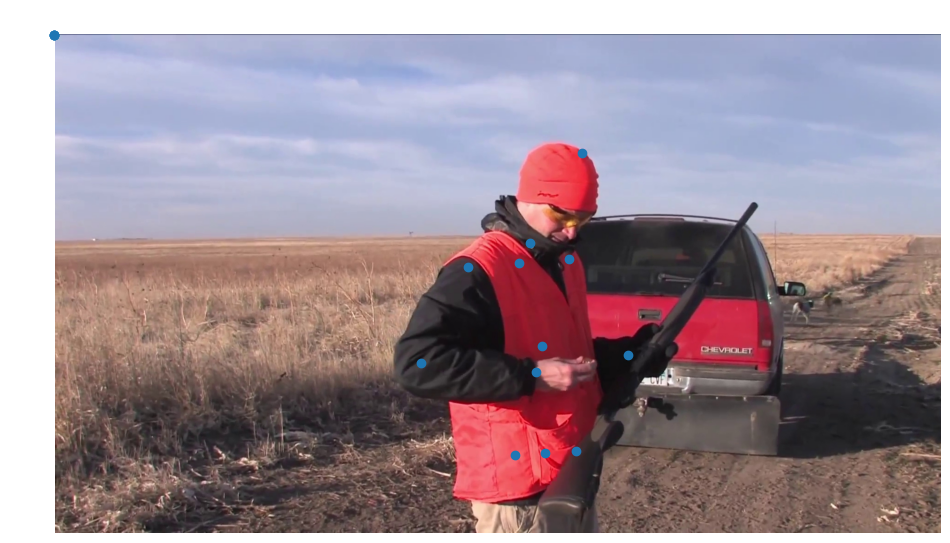

In [4]:
import matplotlib.pyplot as plt 
from PIL import Image

image_name = '045313633.jpg'

sample_img = Image.open(os.path.join('./dataset', image_name))
sample_keypoints = data[data['NAME'] == image_name]

Xs = [sample_keypoints[col].values[0] for col in KEYPOINTS_COLUMN_NAMES if col.endswith('_X')]
Ys = [sample_keypoints[col].values[0] for col in KEYPOINTS_COLUMN_NAMES if col.endswith('_Y')]

plt.figure(figsize=(12, 7))

plt.imshow(sample_img)
plt.scatter(Xs, Ys)
plt.axis('off')

plt.show()

In [5]:
# train/validate разбиение

train_val_partition = 0.80
train_val_n = int(train_val_partition * len(data))

train_data = data.iloc[:train_val_n]
val_data = data.iloc[train_val_n:]

In [6]:
# Выбираем классы

idx_class = {i: cat for i, cat in enumerate(data['Category'].unique())}
class_idx = {cat: i for i, cat in idx_class.items()}

idx_class

{0: 'bicycling',
 1: 'home activities',
 2: 'fishing and hunting',
 3: 'sports',
 4: 'water activities',
 5: 'running',
 6: 'winter activities',
 7: 'walking',
 8: 'inactivity quiet/light',
 9: 'transportation',
 10: 'miscellaneous',
 11: 'home repair',
 12: 'occupation',
 13: 'conditioning exercise',
 14: 'lawn and garden'}

In [7]:
def write_label_date(row, dir, image_name, bbox_offset=50):
    img = Image.open(os.path.join('./dataset', f'{image_name}.jpg'))
    width, height = img.width, img.height

    point_names = list(set([col.split('_')[0] for col in KEYPOINTS_COLUMN_NAMES]))
    Xs = [float(row[col+'_X']) for col in point_names if row[col+'_X'] > 0]
    Ys = [float(row[col+'_Y']) for col in point_names if row[col+'_Y'] > 0]
    min_x, max_x = max(min(Xs) - bbox_offset, 0), min(max(Xs) + bbox_offset, width)
    min_y, max_y = max(min(Ys) - bbox_offset, 0), min(max(Ys) + bbox_offset, height)
    
        
    with open(os.path.join(dir, image_name+'.txt'), 'w') as label_file:
        str_out = ""
        str_out += str(class_idx[row['Category']]) + " "
        str_out += str((min_x + (max_x - min_x) / 2) / width) + " "
        str_out += str((min_y + (max_y - min_y) / 2) / height) + " "
        str_out += str((max_x - min_x) / width) + " "
        str_out += str((max_y - min_y) / height) + " "

        for point in point_names:
            x = float(row[point+'_X'])
            y = float(row[point+'_Y'])

            if x < 0 or y < 0:
                str_out += "0.0 0.0 0 "
            else:
                str_out += str(x / width) + " " + str(y / height) + " 2 "
        
        label_file.write(str_out)

In [8]:
# Конвертируем датасет в формат yolov

yolov_ds_path = './yolov_dataset'


os.makedirs(yolov_ds_path, exist_ok=True)
for part in ['train', 'valid']:
    os.makedirs(os.path.join(yolov_ds_path, part, 'images'), exist_ok=True)
    os.makedirs(os.path.join(yolov_ds_path, part, 'labels'), exist_ok=True)

# train
for _, row in train_data.iterrows():
    image_name = row['NAME'].split('.')[0]
    img = Image.open(os.path.join('./dataset', f'{image_name}.jpg'))

    shutil.copy(
        f'./dataset/{image_name}.jpg',
        f'{yolov_ds_path}/train/images/{image_name}.jpg'
    )

    write_label_date(row, f'{yolov_ds_path}/train/labels/', image_name)

#validate
for _, row in val_data.iterrows():
    image_name = row['NAME'].split('.')[0]
    img = Image.open(os.path.join('./dataset', f'{image_name}.jpg'))

    shutil.copy(
        f'./dataset/{image_name}.jpg',
        f'{yolov_ds_path}/valid/images/{image_name}.jpg'
    )

    write_label_date(row, f'{yolov_ds_path}/valid/labels/', image_name)

In [9]:
print("Размер тренировочной выборки: ", len(train_data))
print("Размер валидационной выборки: ", len(val_data))
print()
print("Количество ключевых точек: ", int(len(KEYPOINTS_COLUMN_NAMES) / 2))
print("Количество состояний для предсказания: ", len(class_idx.keys()))

Размер тренировочной выборки:  631
Размер валидационной выборки:  158

Количество ключевых точек:  16
Количество состояний для предсказания:  15


***

## Модель

In [10]:
from ultralytics import YOLO

model = YOLO('yolov8s-pose.pt')

In [13]:
results = model.train(data='./yolov_dataset/data.yaml', epochs=100, imgsz=640, batch=8)

Ultralytics YOLOv8.2.11  Python-3.9.19 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=pose, mode=train, model=yolov8s-pose.pt, data=./yolov_dataset/data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning C:\VSCodeProjects\PatternRecognition\KT3\yolov_dataset\train\labels.cache... 631 images, 0 backgrounds, 0 corrupt: 100%|██████████| 631/631 [00:00<?, ?it/s]Scanning C:\VSCodeProjects\PatternRecognition\KT3\yolov_dataset\train\labels.cache... 631 images, 0 backgrounds, 0 corrupt: 100%|██████████| 631/631 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\VSCodeProjects\PatternRecognition\KT3\yolov_dataset\valid\labels.cache... 158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:00<?, ?it/s]Scanning C:\VSCodeProjects\PatternRecognition\KT3\yolov_dataset\valid\labels.cache... 158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:00<?, ?it/s]


Plotting labels to runs\pose\train8\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\pose\train8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.34G      1.073      6.728     0.5605      2.096      1.217         15        640: 100%|██████████| 79/79 [00:17<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


                   all        158        158     0.0307      0.816      0.103     0.0669      0.649     0.0133     0.0188    0.00202

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.2G     0.9426      6.679     0.5548      1.933      1.138         19        640:  13%|█▎        | 10/79 [00:02<00:13,  5.15it/s]wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 1 is less than current step: 8. Dropping entry: {'train/box_loss': 1.07253, 'train/pose_loss': 6.72826, 'train/kobj_loss': 0.56048, 'train/cls_loss': 2.09576, 'train/dfl_loss': 1.2169, '_timestamp': 1715287253.5001028}).
wandb: WARNING (User provided step: 1 is less than current step: 8. Dropping entry: {'lr/pg0': 0.0001731139240506329, 'lr/pg1': 0.0001731139240506329, 'lr/pg2': 0.0001731139240506329, '_timestamp': 1715287253.5011005}).
wandb: WARNING (User provided step: 1 is less than current step: 8. Dropping entry: {'metrics/precision(B)': 0.03073, 'metrics/recall(B)': 0.81624, 'metrics/mAP50(B)': 0.10289, 'metrics/mAP50-95(B)': 0.06693, 'metrics/

                   all        158        158     0.0438       0.75     0.0944     0.0582    0.00645      0.168    0.00825    0.00117

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/100       2.2G      1.029       6.76     0.5365       1.87      1.169         15        640:  89%|████████▊ | 70/79 [00:13<00:01,  5.28it/s]wandb: WARNING (User provided step: 2 is less than current step: 8. Dropping entry: {'metrics/precision(B)': 0.04375, 'metrics/recall(B)': 0.74999, 'metrics/mAP50(B)': 0.09443, 'metrics/mAP50-95(B)': 0.05816, 'metrics/precision(P)': 0.00645, 'metrics/recall(P)': 0.16797, 'metrics/mAP50(P)': 0.00825, 'metrics/mAP50-95(P)': 0.00117, 'val/box_loss': 1.23004, 'val/pose_loss': 6.41489, 'val/kobj_loss': 0.32878, 'val/cls_loss': 3.55699, 'val/dfl_loss': 1.35087, '_timestamp': 1715287275.0771036}).
      3/100       2.2G      1.027       6.76     0.5406      1.879      1.173         17        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


                   all        158        158     0.0334      0.774       0.11     0.0578      0.643     0.0133    0.00968     0.0014

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.2G      1.056      6.503     0.5342      1.853      1.211         16        640:  71%|███████   | 56/79 [00:10<00:04,  5.38it/s]wandb: WARNING (User provided step: 3 is less than current step: 8. Dropping entry: {'train/box_loss': 1.02653, 'train/pose_loss': 6.76008, 'train/kobj_loss': 0.5406, 'train/cls_loss': 1.8794, 'train/dfl_loss': 1.17274, '_timestamp': 1715287290.662273}).
wandb: WARNING (User provided step: 3 is less than current step: 8. Dropping entry: {'lr/pg0': 0.0005134097350210971, 'lr/pg1': 0.0005134097350210971, 'lr/pg2': 0.0005134097350210971, '_timestamp': 1715287290.662273}).
wandb: WARNING (User provided step: 3 is less than current step: 8. Dropping entry: {'metrics/precision(B)': 0.03345, 'metrics/recall(B)': 0.77358, 'metrics/mAP50(B)': 0.10968, 'metrics/mAP50-95(B)': 0.0578, 'metrics/precision(P)': 0.64301, 'metrics/recall(P)': 0.0133, 'metrics/mAP50(P)': 0.00968, 'metrics/mAP50-95(P)': 0.0014, 'val/box_loss': 1.271, 'val/pose_loss': 6.60713,

                   all        158        158     0.0543      0.584      0.103     0.0574      0.516     0.0106    0.00753    0.00095

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.2G      1.052       6.71     0.5409      1.813      1.192         20        640:  53%|█████▎    | 42/79 [00:07<00:06,  5.40it/s]wandb: WARNING (User provided step: 4 is less than current step: 8. Dropping entry: {'train/box_loss': 1.04619, 'train/pose_loss': 6.52532, 'train/kobj_loss': 0.53222, 'train/cls_loss': 1.84744, 'train/dfl_loss': 1.20688, '_timestamp': 1715287308.476276}).
wandb: WARNING (User provided step: 4 is less than current step: 8. Dropping entry: {'lr/pg0': 0.0005103778, 'lr/pg1': 0.0005103778, 'lr/pg2': 0.0005103778, '_timestamp': 1715287308.476276}).
wandb: WARNING (User provided step: 4 is less than current step: 8. Dropping entry: {'metrics/precision(B)': 0.0543, 'metrics/recall(B)': 0.58413, 'metrics/mAP50(B)': 0.10349, 'metrics/mAP50-95(B)': 0.05744, 'metrics/precision(P)': 0.51625, 'metrics/recall(P)': 0.01064, 'metrics/mAP50(P)': 0.00753, 'metrics/mAP50-95(P)': 0.00095, 'val/box_loss': 1.36215, 'val/pose_loss': 6.51759, 'val/kobj_loss': 0.3

                   all        158        158     0.0545      0.453     0.0912     0.0552      0.405     0.0186     0.0153    0.00233

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.19G        1.1      6.556      0.543      1.814      1.229         16        640:  34%|███▍      | 27/79 [00:05<00:09,  5.36it/s]wandb: WARNING (User provided step: 5 is less than current step: 8. Dropping entry: {'train/box_loss': 1.05954, 'train/pose_loss': 6.57146, 'train/kobj_loss': 0.54297, 'train/cls_loss': 1.81715, 'train/dfl_loss': 1.19332, '_timestamp': 1715287326.0922735}).
      6/100      2.19G        1.1      6.556      0.543      1.814      1.229         16        640:  35%|███▌      | 28/79 [00:05<00:10,  4.83it/s]wandb: WARNING (User provided step: 5 is less than current step: 8. Dropping entry: {'lr/pg0': 0.0005051703999999999, 'lr/pg1': 0.0005051703999999999, 'lr/pg2': 0.0005051703999999999, '_timestamp': 1715287326.0922735}).
wandb: WARNING (User provided step: 5 is less than current step: 8. Dropping entry: {'metrics/precision(B)': 0.05445, 'metrics/recall(B)': 0.45325, 'metrics/mAP50(B)': 0.09121, 'metrics/mAP50-95(B)': 0.05522, 'metrics/precisio

                   all        158        158     0.0449      0.683      0.147     0.0778     0.0117      0.169     0.0197    0.00265

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.19G     0.9712      6.324      0.507      1.734      1.125         21        640:  15%|█▌        | 12/79 [00:02<00:13,  4.90it/s]wandb: WARNING (User provided step: 6 is less than current step: 8. Dropping entry: {'train/box_loss': 1.06062, 'train/pose_loss': 6.50765, 'train/kobj_loss': 0.53668, 'train/cls_loss': 1.73911, 'train/dfl_loss': 1.19916, '_timestamp': 1715287344.0038831}).
wandb: WARNING (User provided step: 6 is less than current step: 8. Dropping entry: {'lr/pg0': 0.000499963, 'lr/pg1': 0.000499963, 'lr/pg2': 0.000499963, '_timestamp': 1715287344.0038831}).
wandb: WARNING (User provided step: 6 is less than current step: 8. Dropping entry: {'metrics/precision(B)': 0.04489, 'metrics/recall(B)': 0.68339, 'metrics/mAP50(B)': 0.14745, 'metrics/mAP50-95(B)': 0.07779, 'metrics/precision(P)': 0.01171, 'metrics/recall(P)': 0.16929, 'metrics/mAP50(P)': 0.01972, 'metrics/mAP50-95(P)': 0.00265, 'val/box_loss': 1.27998, 'val/pose_loss': 6.25644, 'val/kobj_loss': 0.3

                   all        158        158      0.194      0.294      0.112     0.0599      0.393      0.065     0.0188    0.00274


wandb: WARNING (User provided step: 7 is less than current step: 8. Dropping entry: {'train/box_loss': 1.01099, 'train/pose_loss': 6.35782, 'train/kobj_loss': 0.51459, 'train/cls_loss': 1.67841, 'train/dfl_loss': 1.1407, '_timestamp': 1715287362.0569227}).
wandb: WARNING (User provided step: 7 is less than current step: 8. Dropping entry: {'lr/pg0': 0.0004947556, 'lr/pg1': 0.0004947556, 'lr/pg2': 0.0004947556, '_timestamp': 1715287362.0569227}).



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.13G      1.018      6.429     0.5341      1.666      1.153         26        640:  95%|█████████▍| 75/79 [00:14<00:00,  5.37it/s]wandb: WARNING (User provided step: 7 is less than current step: 8. Dropping entry: {'metrics/precision(B)': 0.19446, 'metrics/recall(B)': 0.29408, 'metrics/mAP50(B)': 0.11186, 'metrics/mAP50-95(B)': 0.05988, 'metrics/precision(P)': 0.39297, 'metrics/recall(P)': 0.06497, 'metrics/mAP50(P)': 0.01884, 'metrics/mAP50-95(P)': 0.00274, 'val/box_loss': 1.27336, 'val/pose_loss': 6.10694, 'val/kobj_loss': 0.29159, 'val/cls_loss': 3.66874, 'val/dfl_loss': 1.36652, '_timestamp': 1715287364.3969266}).
      8/100      2.13G      1.019        6.4     0.5294      1.661      1.149         15        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


                   all        158        158     0.0633      0.306       0.11     0.0635      0.662      0.016     0.0194    0.00254

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.19G      1.045      6.476     0.5089      1.643      1.175         19        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


                   all        158        158      0.118      0.346       0.12     0.0727     0.0426     0.0737     0.0269    0.00331

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.16G      1.041      6.285     0.5188      1.594      1.174         15        640: 100%|██████████| 79/79 [00:15<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


                   all        158        158     0.0455      0.744       0.11      0.064      0.561     0.0266     0.0223    0.00238

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.2G      1.056      6.353     0.5171      1.603      1.168         16        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


                   all        158        158     0.0427       0.73     0.0934     0.0601      0.139     0.0729     0.0181    0.00259

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.19G       1.03      6.152     0.5141      1.544      1.162         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


                   all        158        158     0.0442      0.765      0.108     0.0606     0.0304     0.0599     0.0197     0.0025

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.13G      1.045      6.199     0.4845      1.546       1.16         19        640: 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


                   all        158        158      0.249       0.37      0.198      0.111      0.159      0.108     0.0297    0.00408

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.19G      1.007      6.095     0.5005       1.48      1.141         11        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


                   all        158        158      0.223      0.338       0.12     0.0765      0.165      0.118     0.0272    0.00404

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.19G      1.022      6.168        0.5       1.52      1.158         13        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


                   all        158        158      0.705      0.179      0.133     0.0753      0.413     0.0631     0.0403    0.00584

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.19G      1.015      6.156     0.4964      1.415      1.159         20        640: 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


                   all        158        158     0.0402      0.724      0.116     0.0674      0.537     0.0631     0.0413    0.00584

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.2G     0.9667      5.903     0.4759      1.399      1.119         15        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


                   all        158        158      0.714      0.144      0.215      0.117      0.152     0.0796     0.0295    0.00428

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.16G     0.9682       6.12     0.4782       1.41      1.126         16        640: 100%|██████████| 79/79 [00:15<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


                   all        158        158     0.0424      0.691     0.0946     0.0555      0.018     0.0676     0.0255    0.00374

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.2G     0.9625      6.044     0.4701      1.352      1.104         21        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


                   all        158        158     0.0901      0.495      0.123     0.0775     0.0564      0.142     0.0519     0.0085

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.19G     0.9615      6.051     0.4734      1.378      1.128          9        640: 100%|██████████| 79/79 [00:15<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


                   all        158        158     0.0792      0.308      0.103     0.0664      0.294     0.0513     0.0298    0.00409

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/100       2.2G     0.9486      5.914     0.4709      1.334      1.113         19        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


                   all        158        158     0.0881      0.327      0.108     0.0683     0.0361      0.118     0.0329    0.00506

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.19G     0.9313      5.865     0.4617      1.319       1.11         16        640: 100%|██████████| 79/79 [00:15<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


                   all        158        158      0.243      0.276      0.151     0.0925      0.284     0.0418      0.026    0.00379

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.19G     0.9368      5.881     0.4552      1.275      1.112         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


                   all        158        158     0.0643      0.309      0.168      0.102     0.0285      0.073       0.04    0.00595

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.19G     0.9141      5.749     0.4496      1.275      1.094         21        640: 100%|██████████| 79/79 [00:15<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


                   all        158        158     0.0918      0.267      0.138     0.0789     0.0552     0.0596     0.0329    0.00541

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.19G     0.9289      5.725     0.4514      1.175      1.099         13        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


                   all        158        158       0.09      0.335      0.121     0.0723     0.0527      0.118     0.0477     0.0075

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.16G     0.8846      5.796     0.4443      1.171      1.078         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


                   all        158        158      0.152      0.262      0.196      0.119     0.0349     0.0975     0.0435    0.00699

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/100       2.2G     0.8832      5.674     0.4519       1.13      1.077         17        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


                   all        158        158      0.102       0.32       0.16      0.106      0.258     0.0708     0.0602    0.00984

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.13G      0.897      5.582     0.4416       1.18      1.085          8        640: 100%|██████████| 79/79 [00:15<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


                   all        158        158      0.244      0.261      0.146     0.0793     0.0553      0.134     0.0437    0.00691

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.19G     0.8573      5.655     0.4328       1.12      1.071         12        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


                   all        158        158      0.385      0.227      0.176      0.095      0.148     0.0935     0.0273    0.00511

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.13G     0.8548      5.676     0.4306      1.102      1.063         19        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


                   all        158        158      0.271      0.238      0.154     0.0844     0.0271      0.122       0.04    0.00656

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.19G      0.823      5.544     0.4153      1.023      1.053         17        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


                   all        158        158      0.272      0.283      0.149     0.0875      0.158     0.0881      0.031    0.00478

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.19G     0.8573      5.593     0.4407       1.08       1.09         19        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.224      0.296      0.126     0.0725      0.426     0.0418     0.0318      0.005

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.2G     0.8124      5.503     0.4123      1.024      1.055         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


                   all        158        158      0.216      0.285      0.211      0.104      0.285     0.0479     0.0405    0.00728

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.16G     0.8361      5.553      0.419     0.9848      1.055         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


                   all        158        158      0.121      0.312      0.176      0.112     0.0571      0.126     0.0603    0.00897

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.19G     0.8172      5.457     0.4072      1.016      1.058         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


                   all        158        158       0.39      0.265      0.155      0.101      0.281     0.0583     0.0294      0.005

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.19G     0.7962      5.443     0.3975     0.9931      1.056         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


                   all        158        158      0.129      0.251      0.165     0.0882     0.0801     0.0591     0.0588    0.00992

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.19G     0.8199      5.453     0.4029     0.9889      1.048         17        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


                   all        158        158      0.256      0.232      0.132      0.086      0.183      0.061     0.0453    0.00737

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.19G     0.7677      5.462     0.4018     0.9561      1.038         17        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


                   all        158        158     0.0853      0.272      0.156     0.0945     0.0355      0.336     0.0522    0.00963

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.15G     0.7871      5.384     0.3894      1.012      1.039         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


                   all        158        158      0.126      0.276      0.147     0.0775     0.0294      0.094     0.0374    0.00621

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.24G     0.7692      5.407     0.3907     0.9215      1.022         18        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


                   all        158        158      0.275      0.258      0.166      0.103     0.0264     0.0907     0.0412    0.00663

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.19G     0.8019      5.404     0.3942     0.9098      1.047         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


                   all        158        158      0.106      0.276      0.186       0.11      0.316     0.0431      0.046    0.00628

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.16G     0.7682      5.338     0.3921     0.9255      1.031         19        640: 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


                   all        158        158      0.148      0.271      0.169     0.0857       0.36     0.0491     0.0596    0.00909

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.19G      0.731      5.214     0.3706     0.8874      1.007         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


                   all        158        158       0.13      0.287      0.146     0.0922     0.0737     0.0962      0.055     0.0107

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.19G     0.7382      5.332     0.3631     0.9076      1.016         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


                   all        158        158      0.458      0.261      0.132     0.0835      0.418      0.065     0.0426    0.00723

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.19G     0.7571      5.294     0.3678     0.8546      1.026         15        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


                   all        158        158      0.284      0.309      0.161      0.111      0.162     0.0988     0.0548    0.00891

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.19G     0.7461      5.256     0.3728     0.8361      1.024         20        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


                   all        158        158        0.3      0.274      0.148     0.0865       0.18     0.0774     0.0476    0.00832

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.19G     0.7439      5.199     0.3696     0.8165      1.021         17        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


                   all        158        158      0.177      0.295      0.159     0.0892     0.0637      0.078     0.0544    0.00872

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.19G      0.751      5.192      0.367     0.8089      1.021         18        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


                   all        158        158       0.39      0.216      0.106     0.0635      0.308     0.0466     0.0464      0.007

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.19G     0.7281      5.128     0.3663     0.8143      1.017         17        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


                   all        158        158      0.458       0.28       0.14     0.0733      0.506     0.0637     0.0585    0.00818

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.15G     0.7202      5.206     0.3664     0.7911      1.014         16        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


                   all        158        158      0.317      0.291      0.176      0.101      0.551     0.0511     0.0577    0.00903

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.19G     0.7064      5.158     0.3526      0.782       1.01         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


                   all        158        158      0.391      0.294      0.166     0.0983      0.194      0.109     0.0665     0.0106

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.19G     0.7131      5.137     0.3604     0.7975      1.022         13        640: 100%|██████████| 79/79 [00:15<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


                   all        158        158      0.525      0.246      0.146     0.0784     0.0632        0.1     0.0438     0.0068

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.24G     0.6951      5.194      0.362     0.7816      1.001         11        640: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


                   all        158        158      0.359      0.218       0.15     0.0865     0.0279      0.224     0.0394    0.00716

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.19G     0.7085       5.02     0.3479     0.8077      1.018         15        640: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


                   all        158        158      0.273      0.276      0.137     0.0916     0.0577       0.12     0.0512     0.0108

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.19G     0.6755      5.081     0.3501     0.7524     0.9937         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


                   all        158        158       0.13      0.285      0.135     0.0788      0.034      0.256     0.0488    0.00873

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.2G     0.6644       5.11     0.3476     0.7293     0.9803         21        640: 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


                   all        158        158      0.474      0.294      0.151     0.0981      0.196      0.124     0.0538    0.00746

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.19G     0.6421      5.002     0.3403     0.6984     0.9766         17        640: 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


                   all        158        158      0.271      0.304      0.149      0.104       0.19      0.114     0.0552     0.0098

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.16G      0.671      5.095     0.3434     0.7412     0.9914         16        640: 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


                   all        158        158      0.116      0.286      0.143     0.0943     0.0583     0.0962     0.0557    0.00886

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.19G       0.67      5.038     0.3506      0.727     0.9912          9        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


                   all        158        158      0.441       0.24      0.149     0.0995      0.327     0.0485     0.0463    0.00704

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.19G     0.6354      5.004     0.3409     0.6674     0.9589         19        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


                   all        158        158      0.296      0.247      0.137     0.0867      0.192     0.0686      0.042    0.00677

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.2G     0.6507      4.927     0.3354     0.6902     0.9748         15        640: 100%|██████████| 79/79 [00:15<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


                   all        158        158       0.13      0.312       0.13     0.0836      0.162     0.0747     0.0327    0.00644

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.19G     0.6793      4.908     0.3463     0.7109     0.9886         11        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


                   all        158        158      0.228      0.266      0.138     0.0849     0.0539      0.113     0.0525     0.0103

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.19G     0.6489      4.847      0.333     0.6883     0.9838         16        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


                   all        158        158      0.109       0.32      0.128     0.0758      0.239     0.0855      0.066       0.01

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.23G     0.6304      4.914     0.3313     0.6381     0.9631         19        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


                   all        158        158      0.412      0.243      0.131     0.0787      0.332     0.0795      0.061     0.0115

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.19G     0.6358      4.802     0.3292      0.641     0.9728         16        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.292      0.253      0.104     0.0584      0.169     0.0703     0.0301     0.0056

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.15G     0.6485      4.873     0.3382     0.6826     0.9855         21        640: 100%|██████████| 79/79 [00:15<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


                   all        158        158       0.11      0.245     0.0949     0.0556      0.188     0.0583      0.039     0.0072

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.19G     0.6171      4.751     0.3226     0.6467     0.9538         10        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


                   all        158        158     0.0779      0.228     0.0966     0.0526     0.0279     0.0604      0.033    0.00585

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.19G     0.5975      4.784     0.3207     0.6242     0.9631         20        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


                   all        158        158      0.136      0.255      0.113     0.0688     0.0926     0.0962     0.0702     0.0113

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.19G     0.6139      4.735     0.3301     0.6538     0.9625         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


                   all        158        158      0.288      0.265      0.135     0.0855      0.244     0.0991     0.0726     0.0134

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.19G     0.6009      4.786     0.3187     0.6341     0.9558         11        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


                   all        158        158      0.145      0.307      0.114     0.0686      0.197     0.0672     0.0457    0.00801

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.19G     0.6083      4.763     0.3281     0.6295     0.9586         18        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


                   all        158        158      0.279      0.314      0.134      0.084      0.196      0.106     0.0492     0.0085

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.19G     0.6033       4.79     0.3281     0.6066     0.9657         16        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


                   all        158        158      0.289      0.248      0.142     0.0908      0.198     0.0663     0.0443     0.0083

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.19G     0.5971      4.744     0.3333     0.6101     0.9654         19        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


                   all        158        158      0.514      0.246      0.149     0.0844      0.444     0.0624     0.0559    0.00885

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.16G     0.5863      4.695     0.3331     0.5946     0.9568         13        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


                   all        158        158      0.162      0.315      0.131     0.0783     0.0581      0.106      0.044    0.00746

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.2G     0.5969       4.75     0.3231     0.6168     0.9539         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.175      0.269      0.123     0.0715     0.0626     0.0904     0.0499    0.00705

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.2G     0.5724      4.665     0.3335     0.5766     0.9639         21        640: 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


                   all        158        158      0.312      0.256      0.126     0.0734      0.219     0.0677     0.0461    0.00759

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.2G     0.5733      4.616     0.3132     0.5882     0.9524         13        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


                   all        158        158      0.183      0.283      0.152     0.0883     0.0884     0.0855     0.0501    0.00855

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.2G     0.5652      4.618     0.3236     0.5865     0.9487         17        640: 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


                   all        158        158      0.248      0.301      0.179      0.112      0.366     0.0597      0.062     0.0112

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.18G      0.582      4.727     0.3099     0.5823     0.9512         16        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


                   all        158        158      0.253      0.322      0.213      0.137      0.342       0.12     0.0671    0.00976

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.2G     0.5516      4.654     0.3235     0.5851     0.9443         11        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


                   all        158        158      0.154      0.328      0.147     0.0962      0.348      0.109     0.0506    0.00891

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.19G     0.5428      4.554     0.3115     0.5414     0.9407         20        640: 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


                   all        158        158      0.141      0.299      0.149        0.1      0.217      0.107     0.0727     0.0119

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.15G     0.5642      4.586     0.3232     0.5575     0.9456         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


                   all        158        158      0.235      0.317      0.158      0.101      0.159      0.074     0.0337    0.00678

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.19G     0.5437       4.53     0.3143     0.5525     0.9466         23        640: 100%|██████████| 79/79 [00:15<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


                   all        158        158      0.317      0.332      0.164      0.104      0.205     0.0829      0.062      0.013

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.19G      0.543      4.524     0.3277     0.5393     0.9404         12        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


                   all        158        158      0.327      0.317       0.16     0.0992      0.257     0.0722     0.0592    0.00997

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.19G     0.5715      4.685     0.3223     0.5851     0.9653         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


                   all        158        158       0.29      0.299      0.143     0.0909      0.513     0.0517     0.0645    0.00993

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.19G     0.5243      4.539     0.3116     0.5312     0.9323          9        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


                   all        158        158      0.216      0.265      0.151     0.0976     0.0927      0.102     0.0667     0.0104

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.19G     0.5444      4.439     0.3252     0.5313     0.9407         13        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


                   all        158        158      0.198      0.284      0.146     0.0961      0.217     0.0677     0.0572    0.00927

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.19G     0.5392      4.545     0.3255     0.5344     0.9376         13        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


                   all        158        158      0.188       0.31      0.151     0.0957      0.368     0.0719     0.0579    0.00815

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.2G     0.5478      4.487     0.3108     0.5457     0.9458         18        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


                   all        158        158      0.198      0.294      0.149     0.0968     0.0758     0.0741     0.0532    0.00799

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.16G     0.5375       4.46     0.3109     0.5335     0.9442         21        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


                   all        158        158      0.204      0.301      0.141     0.0836      0.309     0.0583     0.0349    0.00536
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



image 1/1 c:\VSCodeProjects\PatternRecognition\KT3\walking.jpg: 320x640 1 walking, 107.0ms
Speed: 3.0ms preprocess, 107.0ms inference, 5.0ms postprocess per image at shape (1, 3, 320, 640)


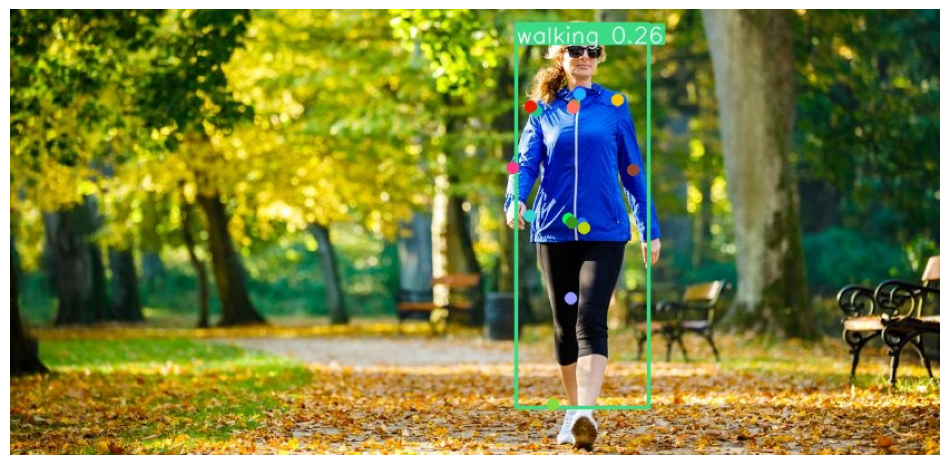

In [19]:
results = model("walking.jpg")

for result in results:
    result.save("result.jpg")

plt.figure(figsize=(12, 7))

plt.imshow(Image.open("result.jpg"))
plt.axis('off')

plt.show()